In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score


## View Results from Hyperparameter Tuning For Current UPDRS
Using the protein and peptide data as well as the visit month, predict the UPDRS value as either Mild, Moderate, or Severe

In [21]:
# read in the data from the csv file for xgboost hyperparameter tuning
xgb_hyperparams_df = pd.read_csv('../data/processed/xgboost_cat_hyperparam_results.csv', index_col=0)
lgb_hyperparams_df = pd.read_csv('../data/processed/lgboost_cat_hyperparam_results.csv', index_col=0)
cboost_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)

In [22]:
lgb_hyperparams_df

updrs_1    updrs_2   updrs_3
colsample_bytree  0.629116   0.856101  0.731011
learning_rate     0.628567   0.750618  0.556761
max_depth         5.000000   8.000000  3.000000
min_child_weight  3.578848  16.437261  5.512251
min_split_gain    0.005489   0.000046  0.000197
reg_alpha         7.735830   6.684875  1.484969
reg_lambda        3.493592   3.002659  3.025202
subsample         0.916682   0.882994  0.556561

In [23]:
xgb_hyperparams_df

updrs_1   updrs_2   updrs_3
colsample_bytree  0.708264  0.694449  0.643855
gamma             1.070175  0.032390  1.949759
learning_rate     0.969325  0.993978  0.502350
max_depth         2.000000  3.000000  2.000000
min_child_weight  0.301500  0.926601  2.980635
reg_alpha         1.641284  5.318046  3.232656
reg_lambda        6.011928  6.999249  7.487927
subsample         0.900018  0.710181  0.885401

In [24]:
cboost_hyperparams_df

updrs_1   updrs_2   updrs_3
bagging_temperature  4.429427  4.095758  1.162359
depth                7.000000  6.000000  4.000000
l2_leaf_reg          5.641367  5.757078  7.356710
learning_rate        0.366781  0.954836  0.973876
min_data_in_leaf     8.000000  8.000000  4.000000

In [25]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

In [26]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

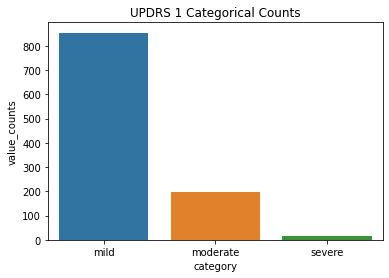

In [27]:
updrs1_val_counts = updrs1_df['updrs_1_cat'].value_counts().reset_index()
updrs1_val_counts.columns = ['category', 'value_counts']

# plot the values
sns.barplot(data=updrs1_val_counts, x='category', y='value_counts')
plt.title("UPDRS 1 Categorical Counts")
plt.show()

In [28]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

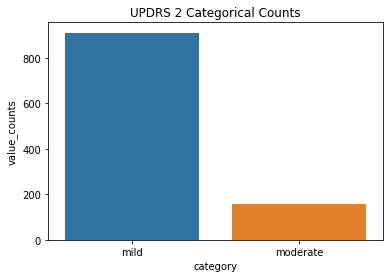

In [29]:
updrs2_val_counts = updrs2_df['updrs_2_cat'].value_counts().reset_index()
updrs2_val_counts.columns = ['category', 'value_counts']

# plot the values
sns.barplot(data=updrs2_val_counts, x='category', y='value_counts')
plt.title("UPDRS 2 Categorical Counts")
plt.show()

In [30]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

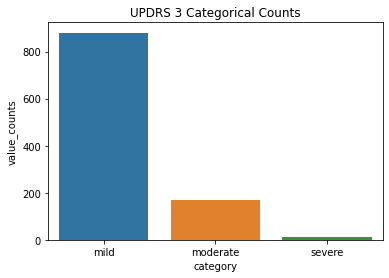

In [31]:
updrs3_val_counts = updrs3_df['updrs_3_cat'].value_counts().reset_index()
updrs3_val_counts.columns = ['category', 'value_counts']

# plot the values
sns.barplot(data=updrs3_val_counts, x='category', y='value_counts')
plt.title("UPDRS 3 Categorical Counts")
plt.show()

In [32]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [33]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [34]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YVNKEIQNAVNGVK_P10909', 'YWGVASFLQK_P02753',
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat'],
      dtype='object', length=1204)

In [35]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(0, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(0, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(0, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(0, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(0, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [36]:
def prepare_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    model = XGBClassifier(**updrs_hp)
    return model

In [37]:
# test the model function
# model = prepare_xgboost_model(xgb_hyperparams_df, 'updrs_1')
# model.get_params()

## Look at Baseline XGBoost Model

In [38]:
xgb_baseline_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = XGBClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_baseline_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

In [39]:
xgb_baseline_results

{'updrs_1': {'auc': 0.5981664858595305,
  'acc': 0.8248870168048793,
  'prec': 0.7046231546231546,
  'recall': 0.21980073202892636},
 'updrs_2': {'auc': 0.5756841909642565,
  'acc': 0.8689087797814927,
  'prec': 0.8253968253968255,
  'recall': 0.1589833425533223},
 'updrs_3': {'auc': 0.5900339663284769,
  'acc': 0.8535232048645265,
  'prec': 0.7504545454545454,
  'recall': 0.19252486782198158}}

## XGBoost HyperParameter Tuned Results

In [40]:
xgb_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = prepare_xgboost_model(xgb_hyperparams_df, updrs)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

In [41]:
xgb_results

{'updrs_1': {'auc': 0.6228153495890046,
  'acc': 0.8033916897020754,
  'prec': 0.5157675273775034,
  'recall': 0.3231265220685688},
 'updrs_2': {'auc': 0.6172550362778326,
  'acc': 0.8642183317976395,
  'prec': 0.5985714285714285,
  'recall': 0.26631630708709814},
 'updrs_3': {'auc': 0.6185961118239277,
  'acc': 0.8591969954395065,
  'prec': 0.7281562881562882,
  'recall': 0.25652528589710255}}

## LightGBM Classifier Results

In [42]:
def prepare_lgboost_model(lgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = lgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    model = LGBMClassifier(**updrs_hp)
    return model

In [43]:
lgb_baseline_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = LGBMClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_baseline_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

[LightGBM] [Info] Number of positive: 171, number of negative: 683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293183
[LightGBM] [Info] Number of data points in the train set: 854, number of used features: 1199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200234 -> initscore=-1.384831
[LightGBM] [Info] Start training from score -1.384831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 176, number of negative: 678
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293236
[LightGBM] [Info] Number of data points in the train set: 854, number of used features: 1199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206089 -> initscore

In [44]:
lgb_baseline_results

{'updrs_1': {'auc': 0.5816450337397866,
  'acc': 0.8220964415778159,
  'prec': 0.736080586080586,
  'recall': 0.18093455749248416},
 'updrs_2': {'auc': 0.5798905770760135,
  'acc': 0.8717212934930455,
  'prec': 0.846984126984127,
  'recall': 0.16522220173335792},
 'updrs_3': {'auc': 0.5930780948726055,
  'acc': 0.8582491281409282,
  'prec': 0.8392063492063493,
  'recall': 0.19297531827243203}}

In [45]:
# view the results of the hyperparameter tuning
lgb_hyperparams_df.head()

updrs_1    updrs_2   updrs_3
colsample_bytree  0.629116   0.856101  0.731011
learning_rate     0.628567   0.750618  0.556761
max_depth         5.000000   8.000000  3.000000
min_child_weight  3.578848  16.437261  5.512251
min_split_gain    0.005489   0.000046  0.000197

In [46]:
lgb_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = prepare_lgboost_model(lgb_hyperparams_df, updrs)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 171, number of negative: 683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293183
[LightGBM] [Info] Number of data points in the train set: 854, number of used features: 1199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200234 -> initscore=-1.384831
[LightGBM] [Info] Start training from score -1.384831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [47]:
lgb_results

{'updrs_1': {'auc': 0.5658502432545193,
  'acc': 0.79680575665833,
  'prec': 0.48523125996810207,
  'recall': 0.1797514852179319},
 'updrs_2': {'auc': 0.5692116705945804,
  'acc': 0.8511078934667193,
  'prec': 0.5183566433566433,
  'recall': 0.1690761571086115},
 'updrs_3': {'auc': 0.6167585795325474,
  'acc': 0.8535097916480373,
  'prec': 0.6657518951636598,
  'recall': 0.2596450440253496}}

In [48]:
train_df = updrs1_df[updrs1_df['kfold'] != 4].reset_index(drop=True)
test_df = updrs1_df[updrs1_df['kfold'] == 4].reset_index(drop=True)
X_train = train_df.drop(columns=['visit_id', 'patient_id', 'updrs_1', 'kfold', 'updrs_1_cat'])
y_train = train_df['updrs_1_cat']
X_test = test_df.drop(columns=['visit_id', 'patient_id', 'updrs_1', 'kfold', 'updrs_1_cat'])
y_test = test_df['updrs_1_cat']

model = prepare_lgboost_model(lgb_hyperparams_df, 'updrs_1')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_df['preds'] = y_pred


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 172, number of negative: 683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293579
[LightGBM] [Info] Number of data points in the train set: 855, number of used features: 1199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201170 -> initscore=-1.379000
[LightGBM] [Info] Start training from score -1.379000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [49]:
model = prepare_lgboost_model(lgb_hyperparams_df, 'updrs_3')
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7310113546368466,
 'importance_type': 'split',
 'learning_rate': 0.5567614720759515,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 5.512250721546523,
 'min_split_gain': 0.0001967260227772,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 1.4849686714281682,
 'reg_lambda': 3.025201814436393,
 'subsample': 0.5565613110107488,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [50]:
test_df['preds'].value_counts()

0    202
1     11
Name: preds, dtype: int64

In [51]:
wrong_preds = test_df[test_df['updrs_1_cat'] != test_df['preds']]
wrong_preds.shape

(41, 1205)

In [52]:
wrong_preds['updrs_1_cat'].value_counts()

1    36
0     5
Name: updrs_1_cat, dtype: int64

## Try the Catboost model

In [52]:
def prepare_catboost_model(cboost_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = cboost_hyperparams_df[target].to_dict()
    updrs_hp['depth'] = int(updrs_hp['depth'])
    updrs_hp['min_data_in_leaf'] = int(updrs_hp['min_data_in_leaf'])
    model = CatBoostClassifier(**updrs_hp)
    return model

In [53]:
# try baseline model results
cb_baseline_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = CatBoostClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cb_baseline_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

Learning rate set to 0.009631
0:	learn: 0.6883983	total: 427ms	remaining: 7m 6s
1:	learn: 0.6835717	total: 639ms	remaining: 5m 19s
2:	learn: 0.6784973	total: 836ms	remaining: 4m 37s
3:	learn: 0.6731266	total: 1.03s	remaining: 4m 15s
4:	learn: 0.6682762	total: 1.22s	remaining: 4m 3s
5:	learn: 0.6635005	total: 1.41s	remaining: 3m 54s
6:	learn: 0.6588721	total: 1.61s	remaining: 3m 47s
7:	learn: 0.6545057	total: 1.79s	remaining: 3m 42s
8:	learn: 0.6502952	total: 1.98s	remaining: 3m 38s
9:	learn: 0.6457062	total: 2.17s	remaining: 3m 35s
10:	learn: 0.6409255	total: 2.37s	remaining: 3m 32s
11:	learn: 0.6361368	total: 2.56s	remaining: 3m 30s
12:	learn: 0.6318137	total: 2.75s	remaining: 3m 28s
13:	learn: 0.6283873	total: 2.93s	remaining: 3m 26s
14:	learn: 0.6243413	total: 3.12s	remaining: 3m 25s
15:	learn: 0.6198635	total: 3.31s	remaining: 3m 23s
16:	learn: 0.6157594	total: 3.5s	remaining: 3m 22s
17:	learn: 0.6115695	total: 3.69s	remaining: 3m 21s
18:	learn: 0.6072867	total: 3.88s	remaining: 3m

In [54]:
cb_baseline_results

{'updrs_1': {'auc': 0.5421688215314153,
  'acc': 0.812719933307007,
  'prec': 0.7933333333333333,
  'recall': 0.09024825292080893},
 'updrs_2': {'auc': 0.5427447352707516,
  'acc': 0.863292527752183,
  'prec': 0.85,
  'recall': 0.08765750814432356},
 'updrs_3': {'auc': 0.5565672272369502,
  'acc': 0.8468970759188054,
  'prec': 0.8342857142857143,
  'recall': 0.11879196683950503}}

In [55]:
cb_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = prepare_catboost_model(cboost_hyperparams_df, updrs)
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cb_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

0:	learn: 0.5490387	total: 413ms	remaining: 6m 52s
1:	learn: 0.4781996	total: 807ms	remaining: 6m 42s
2:	learn: 0.4375315	total: 1.15s	remaining: 6m 22s
3:	learn: 0.3825155	total: 1.49s	remaining: 6m 10s
4:	learn: 0.3527269	total: 1.82s	remaining: 6m 3s
5:	learn: 0.3360555	total: 2.16s	remaining: 5m 57s
6:	learn: 0.3095472	total: 2.49s	remaining: 5m 53s
7:	learn: 0.2947633	total: 2.84s	remaining: 5m 52s
8:	learn: 0.2652551	total: 3.17s	remaining: 5m 49s
9:	learn: 0.2451064	total: 3.51s	remaining: 5m 47s
10:	learn: 0.2299863	total: 3.84s	remaining: 5m 45s
11:	learn: 0.2136857	total: 4.17s	remaining: 5m 43s
12:	learn: 0.2006115	total: 4.51s	remaining: 5m 42s
13:	learn: 0.1817324	total: 4.84s	remaining: 5m 40s
14:	learn: 0.1790238	total: 5.17s	remaining: 5m 39s
15:	learn: 0.1760457	total: 5.5s	remaining: 5m 38s
16:	learn: 0.1668222	total: 5.83s	remaining: 5m 37s
17:	learn: 0.1550962	total: 6.17s	remaining: 5m 36s
18:	learn: 0.1450576	total: 6.5s	remaining: 5m 35s
19:	learn: 0.1366716	tota

252:	learn: 0.0023966	total: 1m 24s	remaining: 4m 9s
253:	learn: 0.0023817	total: 1m 24s	remaining: 4m 9s
254:	learn: 0.0023817	total: 1m 25s	remaining: 4m 8s
255:	learn: 0.0023722	total: 1m 25s	remaining: 4m 8s
256:	learn: 0.0023640	total: 1m 25s	remaining: 4m 8s
257:	learn: 0.0023640	total: 1m 26s	remaining: 4m 7s
258:	learn: 0.0023639	total: 1m 26s	remaining: 4m 7s
259:	learn: 0.0023486	total: 1m 26s	remaining: 4m 7s
260:	learn: 0.0023390	total: 1m 27s	remaining: 4m 6s
261:	learn: 0.0023306	total: 1m 27s	remaining: 4m 6s
262:	learn: 0.0023126	total: 1m 27s	remaining: 4m 6s
263:	learn: 0.0023077	total: 1m 28s	remaining: 4m 5s
264:	learn: 0.0022926	total: 1m 28s	remaining: 4m 5s
265:	learn: 0.0022797	total: 1m 28s	remaining: 4m 5s
266:	learn: 0.0022707	total: 1m 29s	remaining: 4m 4s
267:	learn: 0.0022666	total: 1m 29s	remaining: 4m 4s
268:	learn: 0.0022584	total: 1m 29s	remaining: 4m 4s
269:	learn: 0.0022362	total: 1m 30s	remaining: 4m 3s
270:	learn: 0.0022158	total: 1m 30s	remaining:

In [56]:
cb_results

{'updrs_1': {'auc': 0.5655864574878996,
  'acc': 0.8145978675793076,
  'prec': 0.6852991452991454,
  'recall': 0.1500078811791866},
 'updrs_2': {'auc': 0.5825360346219904,
  'acc': 0.8614277565705761,
  'prec': 0.6100000000000001,
  'recall': 0.1859118569057717},
 'updrs_3': {'auc': 0.5857469135310117,
  'acc': 0.8364928909952607,
  'prec': 0.5243686868686869,
  'recall': 0.20771068181934055}}

## View XGBoost Results with Forecasting the UPDRS

In [57]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [58]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [59]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

In [60]:
xgb_forecast_hyperparams_df = pd.read_csv('../data/processed/xgboost_future_cat_hyperparam_results.csv', index_col=0)
lgb_forecast_hyperparams_df = pd.read_csv('../data/processed/lgboost_future_cat_hyperparam_results.csv', index_col=0)
cboost_forecast_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)

In [61]:
lgb_forecast_hyperparams_df

updrs_1   updrs_2    updrs_3
colsample_bytree  0.970757  0.903629   0.686326
learning_rate     0.983567  0.174551   0.910126
max_depth         8.000000  2.000000   6.000000
min_child_weight  1.232586  2.797518  13.387500
min_split_gain    0.007964  0.297876   0.004011
reg_alpha         7.437594  1.543678   4.159710
reg_lambda        7.499285  3.401574   1.926977
subsample         0.728666  0.948910   0.839655

In [62]:
xgb_forecast_hyperparams_df

updrs_1   updrs_2   updrs_3
colsample_bytree  0.999434  0.972336  0.579427
gamma             0.218284  0.108280  0.000070
learning_rate     0.876356  0.650330  0.759742
max_depth         6.000000  8.000000  8.000000
min_child_weight  0.292568  7.076801  0.642850
reg_alpha         6.803953  2.521598  2.426225
reg_lambda        1.268909  1.677160  3.504071
subsample         0.535242  0.682804  0.693480

In [63]:
cboost_hyperparams_df

updrs_1   updrs_2   updrs_3
bagging_temperature  4.429427  4.095758  1.162359
depth                7.000000  6.000000  4.000000
l2_leaf_reg          5.641367  5.757078  7.356710
learning_rate        0.366781  0.954836  0.973876
min_data_in_leaf     8.000000  8.000000  4.000000

## Baseline XGBoost Future Forecast

In [64]:
# try baseline model results
xgb_baseline_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = XGBClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_baseline_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

In [65]:
xgb_baseline_forecast_results

{'updrs_1': {'auc': 0.7979435309633277,
  'acc': 0.8726427098416041,
  'prec': 0.6897873554156078,
  'recall': 0.6720509565116025},
 'updrs_2': {'auc': 0.7907871090881774,
  'acc': 0.9138563468035628,
  'prec': 0.7711247947454843,
  'recall': 0.6154219681603048},
 'updrs_3': {'auc': 0.7525704150035804,
  'acc': 0.8752257891442368,
  'prec': 0.6506017579445571,
  'recall': 0.5675119941673422}}

In [66]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9994339895225436, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.2182840730386759, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.8763564203413519, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 0.2925675445213144, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 6.803952572268468, 'reg_lambda': 1.2689093632909028, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5352418739052822, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}




In [67]:
xgb_forecast_results

{'updrs_1': {'auc': 0.6493186328197951,
  'acc': 0.6743910764901406,
  'prec': 0.5923254099116168,
  'recall': 0.5364276778093467},
 'updrs_2': {'auc': 0.6548371574182562,
  'acc': 0.7431776556776557,
  'prec': 0.6170812324929973,
  'recall': 0.4286708074534161},
 'updrs_3': {'auc': 0.6416416876381418,
  'acc': 0.6779819471308833,
  'prec': 0.6093808353808353,
  'recall': 0.47740751178520197}}

## LGBoost Future Categorical Predictions

### View Baseline Future Forecast First

In [68]:
# try baseline model results
lgb_baseline_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = LGBMClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_baseline_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

In [69]:
lgb_baseline_forecast_results

{'updrs_1': {'auc': 0.8067767640636966,
  'acc': 0.8707735509630995,
  'prec': 0.6790270958356065,
  'recall': 0.699058009026611},
 'updrs_2': {'auc': 0.7871526626908627,
  'acc': 0.9110394453951122,
  'prec': 0.7533799533799534,
  'recall': 0.6103755608826602},
 'updrs_3': {'auc': 0.7501548249836325,
  'acc': 0.8780738621121345,
  'prec': 0.6670203591014949,
  'recall': 0.5570045427430826}}

In [70]:
lgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(model.get_params())
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.970757221693757, 'importance_type': 'split', 'learning_rate': 0.9835668264286576, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 1.2325864748203452, 'min_split_gain': 0.007964040585614, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 7.437593735288674, 'reg_lambda': 7.499284502976287, 'silent': 'warn', 'subsample': 0.7286661893753408, 'subsample_for_bin': 200000, 'subsample_freq': 0}


UPDRS: updrs_2
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9036286590547646, 'importance_type': 'split', 'learning_rate': 0.1745511363640152, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 2.7975180017133723, 'min_split_gain': 0.2978757291694001, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 1.5436778945279928, 'reg_lambda': 3.401574051688944, 'silen

In [71]:
lgb_forecast_results

{'updrs_1': {'auc': 0.59664793015473,
  'acc': 0.6300638403447596,
  'prec': 0.5485747458161251,
  'recall': 0.41962947373344095},
 'updrs_2': {'auc': 0.6251290954000639,
  'acc': 0.7347631535131536,
  'prec': 0.6323177476118652,
  'recall': 0.33857255787690566},
 'updrs_3': {'auc': 0.5969516130707487,
  'acc': 0.6313568096484241,
  'prec': 0.531607724043764,
  'recall': 0.4460611805697889}}

## Compare Catboost Model

### View Baseline Future Forecast First

In [72]:
# try baseline model results
cb_baseline_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_df, updrs2_df, updrs3_df]):
    model = CatBoostClassifier()
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cb_baseline_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

Learning rate set to 0.009631
0:	learn: 0.6797711	total: 218ms	remaining: 3m 37s
1:	learn: 0.6667326	total: 407ms	remaining: 3m 22s
2:	learn: 0.6532223	total: 599ms	remaining: 3m 19s
3:	learn: 0.6407512	total: 791ms	remaining: 3m 16s
4:	learn: 0.6275973	total: 982ms	remaining: 3m 15s
5:	learn: 0.6156133	total: 1.17s	remaining: 3m 14s
6:	learn: 0.6036914	total: 1.36s	remaining: 3m 13s
7:	learn: 0.5927066	total: 1.55s	remaining: 3m 12s
8:	learn: 0.5805824	total: 1.74s	remaining: 3m 11s
9:	learn: 0.5697752	total: 1.93s	remaining: 3m 11s
10:	learn: 0.5582633	total: 2.12s	remaining: 3m 10s
11:	learn: 0.5483598	total: 2.32s	remaining: 3m 10s
12:	learn: 0.5391989	total: 2.51s	remaining: 3m 10s
13:	learn: 0.5288337	total: 2.7s	remaining: 3m 10s
14:	learn: 0.5188260	total: 2.89s	remaining: 3m 9s
15:	learn: 0.5089958	total: 3.08s	remaining: 3m 9s
16:	learn: 0.5003507	total: 3.27s	remaining: 3m 8s
17:	learn: 0.4929250	total: 3.46s	remaining: 3m 8s
18:	learn: 0.4847983	total: 3.65s	remaining: 3m 8

In [73]:
cb_baseline_forecast_results

{'updrs_1': {'auc': 0.8051637260645561,
  'acc': 0.8698565223114387,
  'prec': 0.6706537035450751,
  'recall': 0.6970347506785163},
 'updrs_2': {'auc': 0.8010998646691962,
  'acc': 0.9147953139397131,
  'prec': 0.7592673992673993,
  'recall': 0.6383182740180711},
 'updrs_3': {'auc': 0.7265887931223539,
  'acc': 0.8790217294107127,
  'prec': 0.708812882519779,
  'recall': 0.4961827702065393}}

In [74]:
cgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df, updrs2_yr_df, updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'learning_rate': 0.3667810794764569, 'depth': 7, 'l2_leaf_reg': 5.641366638454, 'bagging_temperature': 4.429427339938372, 'min_data_in_leaf': 8}


0:	learn: 0.5963738	total: 422ms	remaining: 7m 1s
1:	learn: 0.5284597	total: 788ms	remaining: 6m 33s
2:	learn: 0.4746137	total: 1.15s	remaining: 6m 21s
3:	learn: 0.4300816	total: 1.5s	remaining: 6m 14s
4:	learn: 0.3818085	total: 1.85s	remaining: 6m 8s
5:	learn: 0.3581032	total: 2.28s	remaining: 6m 18s
6:	learn: 0.3207035	total: 2.63s	remaining: 6m 13s
7:	learn: 0.2842228	total: 2.98s	remaining: 6m 9s
8:	learn: 0.2642686	total: 3.32s	remaining: 6m 5s
9:	learn: 0.2496465	total: 3.67s	remaining: 6m 3s
10:	learn: 0.2323175	total: 4.02s	remaining: 6m 1s
11:	learn: 0.2093347	total: 4.37s	remaining: 5m 59s
12:	learn: 0.1869236	total: 4.73s	remaining: 5m 58s
13:	learn: 0.1678829	total: 5.08s	remaining: 5m 57s
14:	learn: 0.1571183	total: 5.44s	remaining: 5m 57s
15:	learn: 0.1523036	total: 5.79s	remaining: 5m 55s
16:	l

In [75]:
cgb_forecast_results

{'updrs_1': {'auc': 0.6985277692731806,
  'acc': 0.7416851077713658,
  'prec': 0.7500276052449966,
  'recall': 0.4998000631379564},
 'updrs_2': {'auc': 0.6758781386273682,
  'acc': 0.7584207459207459,
  'prec': 0.6635450057189187,
  'recall': 0.4589595332204028},
 'updrs_3': {'auc': 0.6531635086306897,
  'acc': 0.6911028937687261,
  'prec': 0.6362310893615241,
  'recall': 0.4842247386759582}}

In [117]:
from sklearn.model_selection import StratifiedKFold

def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [160]:
def train_catboost(train_df, test_df, updrs):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_val = val_df.drop([f'{updrs}_cat','kfold'] axis=1)
    y_val = val_df[f'{updrs}_cat']

    # Define the CatBoost classifier
    model = CatBoostClassifier(iterations=1000, eval_metric='AUC', random_seed=42)

    # Fit the model on the training data
    model.fit(features, 
              target,
                #early_stopping_rounds=50, 
                verbose=100)

    # Make predictions on the test data
    predictions = model.predict_proba(test_df)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(test_df[f'{updrs}_cat'], predictions)
    print("AUC on Test Data:", auc)

    # Save the best iteration of the model
    model.save_model(f'../models/catboost_{updrs}_model.cbm', format='cbm', pool=None)

    return model

In [174]:
# train and save the best catboost model for each updrs
cboost_results = dict()

for updrs, df in zip(['updrs_1'], [updrs1_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}



    

5 Kfolds created for updrs_1_cat
Learning rate set to 0.023058
0:	test: 0.4894349	best: 0.4894349 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.6599509	best: 0.6633907 (98)	total: 20.3s	remaining: 3m
200:	test: 0.6914005	best: 0.6914005 (169)	total: 38.9s	remaining: 2m 34s
300:	test: 0.7027027	best: 0.7071253 (287)	total: 57.5s	remaining: 2m 13s
400:	test: 0.7115479	best: 0.7154791 (386)	total: 1m 16s	remaining: 1m 53s
500:	test: 0.7159705	best: 0.7169533 (477)	total: 1m 34s	remaining: 1m 34s
600:	test: 0.7130221	best: 0.7169533 (477)	total: 1m 53s	remaining: 1m 15s
700:	test: 0.7135135	best: 0.7169533 (477)	total: 2m 11s	remaining: 56.3s
800:	test: 0.7233415	best: 0.7243243 (785)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7233415	best: 0.7248157 (808)	total: 2m 49s	remaining: 18.6s
999:	test: 0.7267813	best: 0.7272727 (960)	total: 3m 7s	remaining: 0us

bestTest = 0.7272727273
bestIteration = 960

Shrink model to first 961 iterations.
AUC on Test Data: 0.7326781326781326


In [175]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6525798525798526, 1.0)

In [176]:
for updrs, df in zip(['updrs_2'], [updrs2_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_2_cat
Learning rate set to 0.023058
0:	test: 0.5623974	best: 0.5623974 (0)	total: 206ms	remaining: 3m 26s
100:	test: 0.7695676	best: 0.7766831 (95)	total: 18.2s	remaining: 2m 42s
200:	test: 0.7996716	best: 0.8111658 (176)	total: 36.1s	remaining: 2m 23s
300:	test: 0.8292282	best: 0.8314176 (299)	total: 54.1s	remaining: 2m 5s
400:	test: 0.8445539	best: 0.8467433 (381)	total: 1m 12s	remaining: 1m 48s
500:	test: 0.8494800	best: 0.8549535 (464)	total: 1m 30s	remaining: 1m 29s
600:	test: 0.8560482	best: 0.8565955 (581)	total: 1m 48s	remaining: 1m 11s
700:	test: 0.8555008	best: 0.8582375 (674)	total: 2m 6s	remaining: 54s
800:	test: 0.8587849	best: 0.8587849 (738)	total: 2m 26s	remaining: 36.4s
900:	test: 0.8576902	best: 0.8593322 (804)	total: 2m 45s	remaining: 18.2s
999:	test: 0.8587849	best: 0.8604269 (946)	total: 3m 4s	remaining: 0us

bestTest = 0.8604269294
bestIteration = 946

Shrink model to first 947 iterations.
AUC on Test Data: 0.8292282430213465


In [177]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6737821565407772, 1.0)

In [178]:
for updrs, df in zip(['updrs_3'], [updrs3_yr_df]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    temp_df, test_kfold = create_folds(df, updrs)
    val_kfold = test_kfold - 1 
    temp_df = temp_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    X_train = temp_df[(temp_df['kfold'] != test_kfold)&(temp_df['kfold']!=val_kfold)].reset_index(drop=True)
    y_train = X_train[f'{updrs}_cat']
    X_test = temp_df[temp_df['kfold'] == test_kfold].reset_index(drop=True)
    y_test = X_test[f'{updrs}_cat']
    val_df = temp_df[temp_df['kfold'] == val_kfold].reset_index(drop=True)
    
    best_model = train_catboost(X_train, val_df, X_test, updrs)
    
    #preds = best_model.predict(X_test.drop(columns = [f'{updrs}_cat', 'kfold']))
    #test_auc = roc_auc_score(y_test, preds)
    #preds = best_model.predict(X_train.drop(columns=[f'{updrs}_cat', 'kfold']))
    #train_auc = roc_auc_score(y_train, preds)
    
    #cboost_results[updrs] = {'test_auc':test_auc, 'train_auc':train_auc}

5 Kfolds created for updrs_3_cat
Learning rate set to 0.023037
0:	test: 0.5795918	best: 0.5795918 (0)	total: 212ms	remaining: 3m 32s
100:	test: 0.6540816	best: 0.6709184 (92)	total: 19s	remaining: 2m 49s
200:	test: 0.6943878	best: 0.6989796 (191)	total: 40.1s	remaining: 2m 39s
300:	test: 0.7306122	best: 0.7311224 (294)	total: 1m 1s	remaining: 2m 23s
400:	test: 0.7372449	best: 0.7403061 (359)	total: 1m 22s	remaining: 2m 3s
500:	test: 0.7494898	best: 0.7510204 (493)	total: 1m 39s	remaining: 1m 39s
600:	test: 0.7530612	best: 0.7556122 (572)	total: 1m 56s	remaining: 1m 17s
700:	test: 0.7551020	best: 0.7571429 (689)	total: 2m 13s	remaining: 57s
800:	test: 0.7586735	best: 0.7602041 (780)	total: 2m 30s	remaining: 37.4s
900:	test: 0.7576531	best: 0.7612245 (822)	total: 2m 47s	remaining: 18.4s
999:	test: 0.7596939	best: 0.7612245 (822)	total: 3m 4s	remaining: 0us

bestTest = 0.7612244898
bestIteration = 822

Shrink model to first 823 iterations.
AUC on Test Data: 0.7775510204081633


In [179]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6303571428571428, 1.0)

## Compare to Logistic Regression Model

In [85]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [86]:
updrs1_results

(0.511721383287093,
 0.780847703040674,
 0.32282051282051283,
 0.062211088895139766)

In [87]:
updrs2_results

(0.5258909849605227,
 0.8464349962704578,
 0.42333333333333323,
 0.07048988874546684)

In [88]:
updrs3_results

(0.5240749211448716,
 0.8194894035589735,
 0.3485714285714286,
 0.07900396151669495)

## Forecast with Logistic Regression

In [89]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [90]:
updrs1_forecast_results

(0.5634874999789138,
 0.5994172665293609,
 0.4912421630094044,
 0.3920253253358589)

In [91]:
updrs2_forecast_results

(0.582742150911908, 0.6805340492840493, 0.4779128959276018, 0.3289821193299454)

In [92]:
updrs3_forecast_results

(0.5758538282007636,
 0.6218648310387985,
 0.5047414576826341,
 0.3744481451117032)